# Analysis of Simulated Data

<!-- ## Package Installation

Make sure to install auto4dstem from source:

```bash
pip install auto4dstem
``` -->

## Importing Required Packages

In [1]:
%load_ext autoreload
%autoreload 2

import os
import torch
import pickle
import numpy as np
import matplotlib.pyplot as plt

from cmcrameri import cm
from auto4dstem.nn.Train_Function import Train
from auto4dstem.masks.masks import Mask
from auto4dstem.viz.diffraction import display_diffraction_image, display_noisy_diffraction
from auto4dstem.viz.simulated_4DSTEM import VisualizeSimulation
from auto4dstem.viz.viz import (
    PlotStyleClass,
    visual_performance_plot,
)
from m3util.util.IO import download_files_from_txt

## GPU Settings

The notebook is designed to run on a system with a GPU accelerator this code will check is a GPU is available. 

In [2]:
!nvidia-smi

Tue Jun  3 16:48:46 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 570.153.02             Driver Version: 570.153.02     CUDA Version: 12.8     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|


|   0  NVIDIA RTX A6000               On  |   00000000:01:00.0 Off |                  Off |
| 30%   32C    P8             17W /  300W |    9745MiB /  49140MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+------------------------+----------------------+


|   1  NVIDIA RTX A6000               On  |   00000000:23:00.0 Off |                  Off |
| 30%   32C    P8             24W /  300W |      18MiB /  49140MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+------------------------+----------------------+
|   2  NVIDIA RTX A6000               On  |   00000000:41:00.0 Off |                  Off |
| 30%   32C    P8             30W /  300W |      18MiB /  49140MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+------------------------+----------------------+
|   3  NVIDIA RTX A6000               On  |   00000000:61:00.0 Off |                  Off |
| 32%   59C    P0            182W /  300W |   24657MiB /  49140MiB |     11%      Default |
|                                         |                        |            

|   4  NVIDIA RTX A6000               On  |   00000000:81:00.0 Off |                  Off |
| 30%   29C    P8              9W /  300W |      18MiB /  49140MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+------------------------+----------------------+
|   5  NVIDIA RTX A6000               On  |   00000000:A1:00.0 Off |                  Off |
| 30%   31C    P8             19W /  300W |     813MiB /  49140MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+------------------------+----------------------+
|   6  NVIDIA RTX A6000               On  |   00000000:C1:00.0 Off |                  Off |
| 30%   31C    P8             16W /  300W |      18MiB /  49140MiB |      0%      Default |
|                                         |                        |            

|   7  NVIDIA RTX A6000               On  |   00000000:E1:00.0 Off |                  Off |
| 30%   31C    P8             27W /  300W |   47033MiB /  49140MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+------------------------+----------------------+
                                                                                         
+-----------------------------------------------------------------------------------------+
| Processes:                                                                              |
|  GPU   GI   CI              PID   Type   Process name                        GPU Memory |
|        ID   ID                                                               Usage      |
|=========================================================================================|
|    0   N/A  N/A            4838      G   /usr/lib/xorg/Xorg                     

Selects the GPU device to use. 

In [3]:
# you can change the device number to the one you want to use
device_number = 0

device = torch.device(f"cuda:{device_number}" if torch.cuda.is_available() else "cpu")
torch.cuda.set_device(device) 
print("Current CUDA device index:", torch.cuda.current_device())

Current CUDA device index: 0


## Visualization Format 

Set the format for standard plotting throughout the notebook

In [4]:
plot_style = PlotStyleClass()
plot_style.apply_global_style()

## Download Data and Pre-Trained Models

In [5]:
data_path = os.path.abspath('./data/simulated_4dstem/')
file_download = f"{data_path}/simulated_data_urls.txt"

# check where are you from the root path
download_files_from_txt(file_download, data_path)

  0%|                                                                                      | 0/72 [00:00<?, ?it/s]

  1%|█                                                                             | 1/72 [00:00<00:36,  1.95it/s]

File already exists: 40percent_noisy_simulated_4dstem_pretrained_weights.pkl


  3%|██▏                                                                           | 2/72 [00:00<00:31,  2.19it/s]

File already exists: 45percent_noisy_simulated_4dstem_pretrained_weights.pkl


  4%|███▎                                                                          | 3/72 [00:01<00:29,  2.31it/s]

File already exists: 60Percent_pretrained_rotation.npy


  6%|████▎                                                                         | 4/72 [00:01<00:28,  2.37it/s]

File already exists: analysis_bg50per_1e5counts__strain.h5


  7%|█████▍                                                                        | 5/72 [00:02<00:27,  2.40it/s]

File already exists: 25percent_noisy_simulated_4dstem_pretrained_weights.pkl


  8%|██████▌                                                                       | 6/72 [00:02<00:27,  2.43it/s]

File already exists: 20Percent_pretrained_rotation.npy


 10%|███████▌                                                                      | 7/72 [00:02<00:26,  2.45it/s]

File already exists: Label_shear_xy.npy


 11%|████████▋                                                                     | 8/72 [00:03<00:26,  2.46it/s]

File already exists: Label_strain_yy.npy


 12%|█████████▊                                                                    | 9/72 [00:03<00:25,  2.47it/s]

File already exists: 25Percent_pretrained_rotation.npy


 14%|██████████▋                                                                  | 10/72 [00:04<00:25,  2.45it/s]

File already exists: 10percent_noisy_simulated_4dstem_pretrained_weights.pkl


 15%|███████████▊                                                                 | 11/72 [00:04<00:24,  2.46it/s]

File already exists: 30percent_noisy_simulated_4dstem_pretrained_weights.pkl


 17%|████████████▊                                                                | 12/72 [00:04<00:24,  2.44it/s]

File already exists: analysis_bg40per_1e5counts__strain.h5


 18%|█████████████▉                                                               | 13/72 [00:05<00:24,  2.45it/s]

File already exists: 05percent_noisy_simulated_4dstem_pretrained_weights.pkl


 19%|██████████████▉                                                              | 14/72 [00:05<00:23,  2.47it/s]

File already exists: 70percent_noisy_simulated_4dstem_pretrained_weights.pkl


 21%|████████████████                                                             | 15/72 [00:06<00:22,  2.48it/s]

File already exists: analysis_bg45per_1e5counts__strain.h5


 22%|█████████████████                                                            | 16/72 [00:06<00:22,  2.49it/s]

File already exists: 00percent_noisy_simulated_4dstem_pretrained_weights.pkl


 24%|██████████████████▏                                                          | 17/72 [00:07<00:25,  2.13it/s]

File already exists: 60percent_noisy_simulated_4dstem_pretrained_weights.pkl


 25%|███████████████████▎                                                         | 18/72 [00:07<00:24,  2.23it/s]

File already exists: 35percent_noisy_simulated_4dstem_pretrained_weights.pkl


 26%|████████████████████▎                                                        | 19/72 [00:08<00:23,  2.29it/s]

File already exists: 00Percent_pretrained_rotation.npy


 28%|█████████████████████▍                                                       | 20/72 [00:08<00:22,  2.36it/s]

File already exists: analysis_bg20per_1e5counts__strain.h5


 29%|██████████████████████▍                                                      | 21/72 [00:08<00:21,  2.33it/s]

File already exists: 20percent_noisy_simulated_4dstem_pretrained_weights.pkl


 31%|███████████████████████▌                                                     | 22/72 [00:09<00:21,  2.36it/s]

File already exists: 50percent_noisy_simulated_4dstem_pretrained_weights.pkl


 32%|████████████████████████▌                                                    | 23/72 [00:09<00:20,  2.40it/s]

File already exists: analysis_bg60per_1e5counts__strain.h5


 33%|█████████████████████████▋                                                   | 24/72 [00:10<00:19,  2.42it/s]

File already exists: analysis_bg70per_1e5counts__strain.h5


 35%|██████████████████████████▋                                                  | 25/72 [00:10<00:19,  2.45it/s]

File already exists: 70Percent_pretrained_rotation.npy


 36%|███████████████████████████▊                                                 | 26/72 [00:10<00:18,  2.45it/s]

File already exists: 45Percent_pretrained_rotation.npy


 38%|████████████████████████████▉                                                | 27/72 [00:11<00:18,  2.47it/s]

File already exists: analysis_bg05per_1e5counts__strain.h5


 39%|█████████████████████████████▉                                               | 28/72 [00:11<00:17,  2.47it/s]

File already exists: analysis_bg15per_1e5counts__strain.h5


 40%|███████████████████████████████                                              | 29/72 [00:12<00:17,  2.43it/s]

File already exists: 15Percent_pretrained_rotation.npy


 42%|████████████████████████████████                                             | 30/72 [00:12<00:17,  2.43it/s]

File already exists: analysis_bg00per_1e5counts__strain.h5


 43%|█████████████████████████████████▏                                           | 31/72 [00:12<00:16,  2.45it/s]

File already exists: analysis_bg30per_1e5counts__strain.h5


 44%|██████████████████████████████████▏                                          | 32/72 [00:13<00:16,  2.43it/s]

File already exists: analysis_bg25per_1e5counts__strain.h5


 46%|███████████████████████████████████▎                                         | 33/72 [00:13<00:15,  2.46it/s]

File already exists: Label_rotation.npy


 47%|████████████████████████████████████▎                                        | 34/72 [00:14<00:15,  2.48it/s]

File already exists: 15percent_noisy_simulated_4dstem_pretrained_weights.pkl


 49%|█████████████████████████████████████▍                                       | 35/72 [00:14<00:14,  2.48it/s]

File already exists: 10Percent_pretrained_rotation.npy


 50%|██████████████████████████████████████▌                                      | 36/72 [00:14<00:14,  2.49it/s]

File already exists: 40Percent_pretrained_rotation.npy


 51%|███████████████████████████████████████▌                                     | 37/72 [00:15<00:13,  2.50it/s]

File already exists: 30Percent_pretrained_rotation.npy


 53%|████████████████████████████████████████▋                                    | 38/72 [00:15<00:13,  2.48it/s]

File already exists: 05Percent_pretrained_rotation.npy


 54%|█████████████████████████████████████████▋                                   | 39/72 [00:16<00:13,  2.47it/s]

File already exists: 35Percent_pretrained_rotation.npy


 56%|██████████████████████████████████████████▊                                  | 40/72 [00:16<00:13,  2.45it/s]

File already exists: analysis_bg10per_1e5counts__strain.h5


 57%|███████████████████████████████████████████▊                                 | 41/72 [00:16<00:12,  2.45it/s]

File already exists: 50Percent_pretrained_rotation.npy


 58%|████████████████████████████████████████████▉                                | 42/72 [00:17<00:12,  2.47it/s]

File already exists: analysis_bg35per_1e5counts__strain.h5


 60%|█████████████████████████████████████████████▉                               | 43/72 [00:17<00:11,  2.47it/s]

File already exists: Label_strain_xx.npy


 61%|███████████████████████████████████████████████                              | 44/72 [00:18<00:11,  2.49it/s]

File already exists: 45Per_2_train_process_scale_shear.npy


 62%|████████████████████████████████████████████████▏                            | 45/72 [00:18<00:10,  2.47it/s]

File already exists: 60Per_2_train_process_scale_shear.npy


 64%|█████████████████████████████████████████████████▏                           | 46/72 [00:18<00:10,  2.47it/s]

File already exists: 30Per_2_train_process_scale_shear.npy


 65%|██████████████████████████████████████████████████▎                          | 47/72 [00:19<00:10,  2.49it/s]

File already exists: 40Per_2_train_process_rotation.npy


 67%|███████████████████████████████████████████████████▎                         | 48/72 [00:19<00:09,  2.46it/s]

File already exists: 10Per_2_train_process_scale_shear.npy


 68%|████████████████████████████████████████████████████▍                        | 49/72 [00:20<00:09,  2.47it/s]

File already exists: 20Per_2_train_process_scale_shear.npy


 69%|█████████████████████████████████████████████████████▍                       | 50/72 [00:20<00:08,  2.48it/s]

File already exists: 30Per_2_train_process_rotation.npy


 71%|██████████████████████████████████████████████████████▌                      | 51/72 [00:21<00:08,  2.43it/s]

File already exists: 05Per_2_train_process_scale_shear.npy


 72%|███████████████████████████████████████████████████████▌                     | 52/72 [00:21<00:08,  2.45it/s]

File already exists: 05Per_2_train_process_rotation.npy


 74%|████████████████████████████████████████████████████████▋                    | 53/72 [00:21<00:07,  2.44it/s]

File already exists: 25Per_2_train_process_rotation.npy


 75%|█████████████████████████████████████████████████████████▊                   | 54/72 [00:22<00:07,  2.41it/s]

File already exists: 45Per_2_train_process_rotation.npy


 76%|██████████████████████████████████████████████████████████▊                  | 55/72 [00:22<00:06,  2.44it/s]

File already exists: 35Per_2_train_process_scale_shear.npy


 78%|███████████████████████████████████████████████████████████▉                 | 56/72 [00:23<00:06,  2.45it/s]

File already exists: 50Per_2_train_process_scale_shear.npy


 79%|████████████████████████████████████████████████████████████▉                | 57/72 [00:23<00:06,  2.43it/s]

File already exists: 70Per_2_train_process_scale_shear.npy


 81%|██████████████████████████████████████████████████████████████               | 58/72 [00:23<00:05,  2.44it/s]

File already exists: 00Per_2_train_process_rotation.npy


 82%|███████████████████████████████████████████████████████████████              | 59/72 [00:24<00:05,  2.44it/s]

File already exists: 10Per_2_train_process_rotation.npy


 83%|████████████████████████████████████████████████████████████████▏            | 60/72 [00:24<00:04,  2.45it/s]

File already exists: 00Per_2_train_process_scale_shear.npy


 85%|█████████████████████████████████████████████████████████████████▏           | 61/72 [00:25<00:04,  2.46it/s]

File already exists: 20Per_2_train_process_rotation.npy


 86%|██████████████████████████████████████████████████████████████████▎          | 62/72 [00:25<00:04,  2.48it/s]

File already exists: 15Per_2_train_process_rotation.npy


 88%|███████████████████████████████████████████████████████████████████▍         | 63/72 [00:25<00:03,  2.49it/s]

File already exists: 35Per_2_train_process_rotation.npy


 89%|████████████████████████████████████████████████████████████████████▍        | 64/72 [00:26<00:03,  2.45it/s]

File already exists: 15Per_2_train_process_scale_shear.npy


 90%|█████████████████████████████████████████████████████████████████████▌       | 65/72 [00:26<00:02,  2.47it/s]

File already exists: 25Per_2_train_process_scale_shear.npy


 92%|██████████████████████████████████████████████████████████████████████▌      | 66/72 [00:27<00:02,  2.47it/s]

File already exists: 40Per_2_train_process_scale_shear.npy


Rate limit reached, waiting to retry...


Rate limit reached, waiting to retry...


Rate limit reached, waiting to retry...


Rate limit reached, waiting to retry...


Rate limit reached, waiting to retry...


Rate limit reached, waiting to retry...


 93%|███████████████████████████████████████████████████████████████████████▋     | 67/72 [01:32<01:39, 19.86s/it]

File already exists: 50Per_2_train_process_rotation.npy


 94%|████████████████████████████████████████████████████████████████████████▋    | 68/72 [01:32<00:56, 14.02s/it]

File already exists: 60Per_2_train_process_rotation.npy


 96%|█████████████████████████████████████████████████████████████████████████▊   | 69/72 [01:33<00:29,  9.94s/it]

File already exists: 70Per_2_train_process_rotation.npy


 97%|██████████████████████████████████████████████████████████████████████████▊  | 70/72 [01:33<00:14,  7.07s/it]

File already exists: simulated_4dstem_grain_index.npy


 99%|███████████████████████████████████████████████████████████████████████████▉ | 71/72 [01:33<00:05,  5.07s/it]

File already exists: MAE_list_simulated_4dstem.pickle


100%|█████████████████████████████████████████████████████████████████████████████| 72/72 [01:34<00:00,  3.67s/it]

100%|█████████████████████████████████████████████████████████████████████████████| 72/72 [01:34<00:00,  1.31s/it]

File already exists: polycrystal_output4D.mat


## Learning Crystallographic Rotation

The first step is to learn the course crystallographic rotation of the data. To do this, we apply a ring mask to the data to calculate the loss in the region of interest where there are diffraction spots. This avoids the central region where there is no diffraction spot - and limited information regarding the crystal structure and strain. 



### Construct Circular Mask

We build a ring mask with inner radius 50 and outer radius 85, to only calculate the loss in the region of interest where there are diffraction spots. 

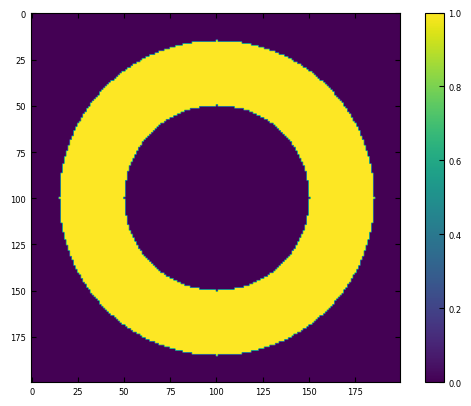

In [6]:
# set mask class
set_mask = Mask()

# generate mask
mask_tensor, mask_list = set_mask.mask_ring(radius_1=50, radius_2=85)

plt.imshow(mask_tensor)
plt.colorbar()
plt.show()

```{figure} ./1x1.png
:name: Circular_Mask

Figure 1: Visualization of the generated mask tensor using a circular mask with inner radius 50 and outer radius 85.
```

## Benchmark Simulated 4DSTEM Dataset

### Set Parameters

Sets the initial Background level (BKG level), Load Data and Pre-Trained Weights

In [7]:
background_intensity = 0
background_string = format(int(background_intensity * 100), "02d")
data_file = os.path.abspath(f"{data_path}/polycrystal_output4D.mat")
rotation_path = f"{data_path}/{background_string}Percent_pretrained_rotation.npy"

## Initialize Training Class

This initializes the training class with the given parameters, and loads the data. 

In [8]:
trainer = Train(
    data_file=data_file,
    device=device,
    coarse_learned_angle_adjustment=0,
    transpose=(1, 0, 3, 2),
    background_weight=background_intensity,
    learned_rotation=rotation_path,
    num_base=1,
    upsample_dimensions=800,
    scale_threshold=0.05,
    shear_threshold=0.1,
    rotation_threshold=0.1,
    translation_threshold=0.15,
    learnable_mask_intensity=0,
    dynamic_mask_to_loss_function=mask_list,
    initial_mask=None,
    interpolate_flag=True,
    reverse_affine_transform_flag=False,
    folder_path=data_path,
)

  0%|                                                                                   | 0/65536 [00:00<?, ?it/s]

 69%|██████████████████████████████████████████████▋                     | 45019/65536 [00:00<00:00, 95193.22it/s]

100%|███████████████████████████████████████████████████████████████████| 65536/65536 [00:00<00:00, 134308.43it/s]

### Random Diffraction Image

Visualization of a random diffraction image from the dataset.

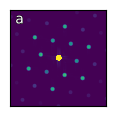

In [9]:
data = trainer.raw_data(index=0)
display_diffraction_image(data, clim=[0, 4e-5])

```{figure} ./1x1.png
:name: Circular_Mask

**Figure 2**: Random diffraction image from 4D-STEM
```

In [10]:
display_noisy_diffraction(data,
    folder_path=os.path.join(folder_path, "figures/"),
    noise_level=[0, 0.25, 0.6],
)

NameError: name 'folder_path' is not defined

**Figure 2:** Diffraction image with various Poisson distributed noise intensity. a) Raw data. b) 10% noise. c) 25% noise. d) 45% noise. e) 60% noise intensity.